In [1]:
%matplotlib inline

In [2]:
import astropy.units as u
from astropy.convolution import Gaussian1DKernel

from spectral_cube import SpectralCube
from radio_beam import Beam

from regions import Regions


In [3]:
from pathlib import Path

sd_data_path = Path("/Users/ekoch/storage/LGLBS/feathering_tests/")
vla_data_path = Path("/Users/ekoch/storage/LGLBS/C+D_HI_2023/")


In [4]:
from uvcombine.scale_factor import find_scale_factor

from cube_analysis.feather_cubes import feather_compare_cube

In [27]:
from cube_analysis.feather_cubes import feather_compare_cube

from cube_analysis.reprojection import reproject_cube

from sklearn.mixture import GaussianMixture

from uvcombine.scale_factor import find_scale_factor

def scalefactor_from_mixturemodel(ratios, ncomp=2, show_plot=False):

    stacked_ratios = np.hstack(ratios)
    stacked_ratios = stacked_ratios[np.isfinite(stacked_ratios)]
    log_ratios = np.log(stacked_ratios).reshape(-1, 1)

    model = GaussianMixture(ncomp).fit(log_ratios)

    sc_factor = np.exp(model.means_)
    sc_err = sc_factor * np.sqrt(np.diagonal(model.covariances_))

    sc_factor = sc_factor.squeeze()
    sc_err = sc_err.squeeze()

    if show_plot:
        x = np.linspace(-5, 5, 1000)
        logprob = model.score_samples(x.reshape(-1, 1))
        responsibilities = model.predict_proba(x.reshape(-1, 1))
        pdf = np.exp(logprob)
        pdf_individual = responsibilities * pdf[:, np.newaxis]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        _ = ax.hist(log_ratios, bins=50, density=True, histtype='stepfilled', alpha=0.4)

        ax.plot(x, pdf, '-k')
        ax.plot(x, pdf_individual, '--k')
        ax.text(0.04, 0.96, "Best-fit Mixture",
                ha='left', va='top', transform=ax.transAxes)

        ax.set_xlabel('log Ratio')
        ax.set_ylabel('PDF')


    return sc_factor, sc_err, model


In [21]:
vla_cube = SpectralCube.read(vla_data_path / "ngc6822_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

gbt_old_cube = SpectralCube.read(sd_data_path / "N6822_GBT.FITS")
# gbt_cube = gbt_cube.with_beam(Beam(8.7*u.arcmin))

# Nick's reprocessed and gridded GBT cube.
gbt_cube = SpectralCube.read(sd_data_path / "NGC6822-center_cube.fits")

# Use the proper beam model size, not the one in the header!
gbt_beam_model = Beam(area=3.69e5 *u.arcsec**2)
gbt_beam_model.major.to(u.arcmin)

gbt_cube = gbt_cube.with_beam(gbt_beam_model)
gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')


In [22]:
print(gbt_cube.beam.major.to(u.arcmin))
print(gbt_old_cube.beam.major.to(u.arcmin))

9.511077544767847 arcmin
8.7054 arcmin


In [23]:
gbt_cube = gbt_cube.with_spectral_unit(u.m / u.s, velocity_convention='radio')

fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = np.abs(np.diff(gbt_cube.spectral_axis)[0]).to(u.km / u.s)
target_resolution = np.abs(np.diff(vla_cube.spectral_axis)[0]).to(u.km / u.s)

gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  current_resolution / fwhm_factor)
print(gaussian_width)
kernel = Gaussian1DKernel(gaussian_width.value)
gbt_cube_specsmooth = gbt_cube.spectral_smooth(kernel)


gbt_cube_specinterp = gbt_cube_specsmooth.spectral_interpolate(vla_cube.spectral_axis)

0.530633586959852


In [24]:
gbt_cube_specinterp = gbt_cube_specinterp.to(u.Jy / u.beam)

In [41]:
output_filename = "NGC6822-center_cube_specmatch_C+D_hilores.fits"

print(sd_data_path / output_filename)

# try:
#     (sd_data_path / output_filename).unlink()
# except FileNotFoundError:
#     pass

gbt_cube_specinterp.write(sd_data_path / output_filename, overwrite=True)

/Users/ekoch/storage/LGLBS/feathering_tests/NGC6822-center_cube_specmatch_C+D_hilores.fits


In [ ]:
# output_filename = "NGC6822-center_cube_matched_to_C+D_hilores.fits"

# try:
#     (sd_data_path / output_filename).unlink()
# except FileNotFoundError:
#     pass

# reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
#                output_filename,
#                output_folder=sd_data_path,
#                reproject_type='spatial',
#                reproject_alg='adaptive')

In [25]:
hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())

In [28]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_cube_specinterp.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


/Users/ekoch/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method,

0.27+/-0.32
0.89+/-1.08


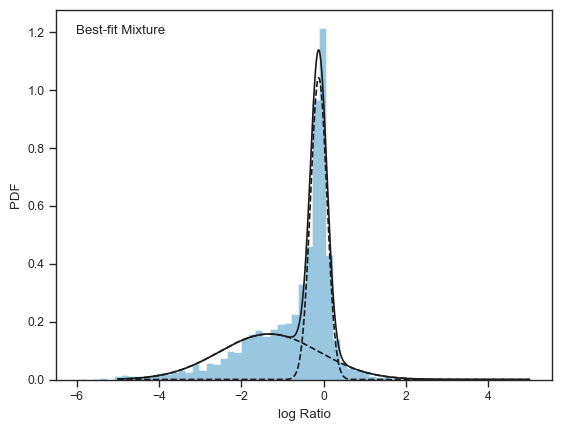

In [54]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios[:-1], ncomp=2, show_plot=True)

# plt.xlim([-1, 1])

# print(f"{sc_factor:.2f}+/-{sc_err:.2f}")
print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

gal_name = 'NGC6822'
# sc_factors[gal_name] = sc_factor[1]
# sc_errs[gal_name] = sc_err[1]
# mix_models[gal_name] = model

0.92+/-0.12
0.83+/-0.11


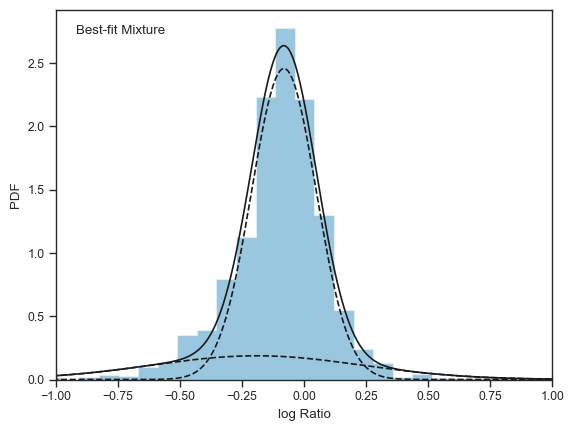

In [42]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios[17:38], ncomp=2, show_plot=True)

plt.xlim([-1, 1])

# print(f"{sc_factor:.2f}+/-{sc_err:.2f}")
print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

gal_name = 'NGC6822'
# sc_factors[gal_name] = sc_factor[1]
# sc_errs[gal_name] = sc_err[1]
# mix_models[gal_name] = model

Velocity range of HI foreground:

0.39+/-0.36
0.05+/-0.04


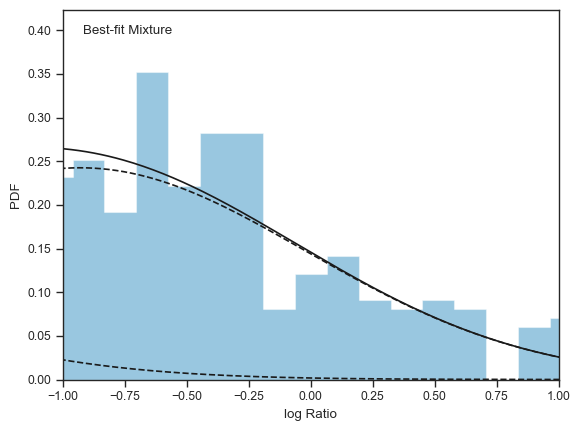

In [43]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios[7:13], ncomp=2, show_plot=True)

plt.xlim([-1, 1])

# print(f"{sc_factor:.2f}+/-{sc_err:.2f}")
print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

gal_name = 'NGC6822'
# sc_factors[gal_name] = sc_factor[1]
# sc_errs[gal_name] = sc_err[1]
# mix_models[gal_name] = model

Optimization terminated successfully.
         Current function value: -0.172819
         Iterations: 43
         Function evaluations: 82
0.92+/-0.00


/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


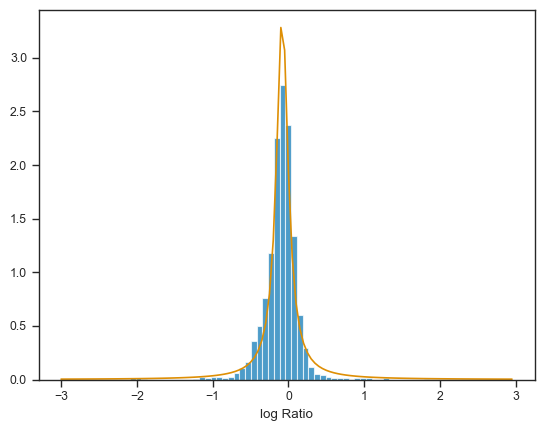

In [49]:
sc_factor, sc_err = find_scale_factor(np.hstack(low_pts[17:38]),
                                      np.hstack(high_pts[17:38]),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")

Try feathering the data without any scaling factor:

In [50]:
from uvcombine import feather_simple_cube

In [51]:
feathered_cube = feather_simple_cube(vla_cube.to(u.K),
                                     gbt_cube_specinterp.to(u.K),
                                     allow_lo_reproj=True)

In [52]:
# feathered_cube.write(vla_data_path / "ngc6822_C+D_hilores_feathered.fits", overwrite=True)

In [53]:
feathered_cube

SpectralCube with shape=(51, 2304, 2400) and unit=K:
 n_x:   2400  type_x: RA---SIN  unit_x: deg    range:   295.376058 deg:  297.105829 deg
 n_y:   2304  type_y: DEC--SIN  unit_y: deg    range:   -15.601865 deg:  -14.002517 deg
 n_s:     51  type_s: VRAD      unit_s: m / s  range:  -147144.203 m / s:   59032.027 m / s